In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

# Dataset

In [2]:
#@title Load the dataset

words1 = open('mkd_names_1.txt', 'r').read().splitlines()
words2 = open('mkd_names_2.txt', 'r').read().splitlines()

words1 = [x.lower() if isinstance(x, str) else x for x in words1]
words2 = [x.lower() if isinstance(x, str) else x for x in words2]

words2_new = [w.split()[0] for w in words2]

words = words1 + words2_new
words = list(dict.fromkeys(words))  # list(set(words))

In [3]:
#@title Vocabulary

# Build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [4]:
#@title Build dataset

BLOCK_SIZE = 8  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(123)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte,  Yte  = build_dataset(words[n2:])    # 10%

torch.Size([2022, 8]) torch.Size([2022])
torch.Size([258, 8]) torch.Size([258])
torch.Size([247, 8]) torch.Size([247])


In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> п
.......п --> а
......па --> р
.....пар --> т
....парт --> е
...парте --> н
..партен --> и
.партени --> ј
партениј --> .
........ --> к
.......к --> а
......ка --> л
.....кал --> и
....кали --> н
...калин --> .
........ --> д
.......д --> а
......да --> р
.....дар --> к
....дарк --> о


# MLP

In [47]:
# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Note: Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)  # Batch mean
      xvar = x.var(0, keepdim=True)  # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers (Exponential moving average)
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # Get the parameters of all layers and stretch them into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [7]:
torch.manual_seed(123)  # seed rng for reprudicibility
# This is a global setting, and it's simpler than using a Generator object

In [48]:
VOCAB_SIZE = 30 + 1
EMBED_SIZE = 10  # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 200  # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_SIZE),
    Flatten(),
    Linear(fan_in=EMBED_SIZE*BLOCK_SIZE, fan_out=HIDDEN_SIZE, bias=False),
    BatchNorm1d(dim=HIDDEN_SIZE),
    Tanh(),
    Linear(fan_in=HIDDEN_SIZE, fan_out=VOCAB_SIZE),
])

# Parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1  # Make the last layer less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

22941


In [49]:
MAX_STEPS = 200000
BATCH_SIZE = 32
lossi = []

for i in range(MAX_STEPS):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)  # Loss function

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0:  # Print every once in a while
    print(f'{i:7d}/{MAX_STEPS:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4290
  10000/ 200000: 1.3676
  20000/ 200000: 0.8682
  30000/ 200000: 1.1484
  40000/ 200000: 0.7224
  50000/ 200000: 0.7013
  60000/ 200000: 0.8743
  70000/ 200000: 0.5282
  80000/ 200000: 0.9310
  90000/ 200000: 0.9960
 100000/ 200000: 0.6768
 110000/ 200000: 0.9338
 120000/ 200000: 1.0317
 130000/ 200000: 0.9144
 140000/ 200000: 0.8775
 150000/ 200000: 0.8730
 160000/ 200000: 0.7533
 170000/ 200000: 0.4502
 180000/ 200000: 0.9654
 190000/ 200000: 0.7760


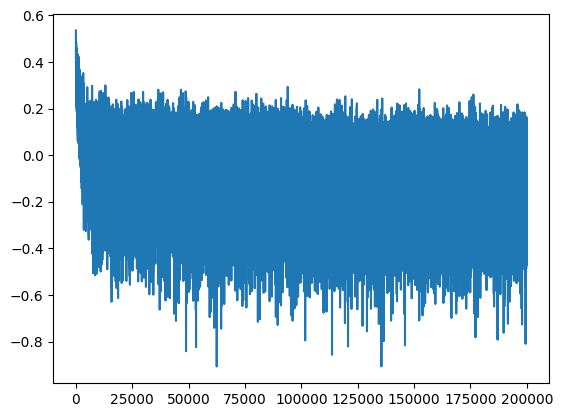

In [50]:
plt.plot(lossi);

In [51]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

In [16]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

In [36]:
lossi[-1]

-0.11120790988206863

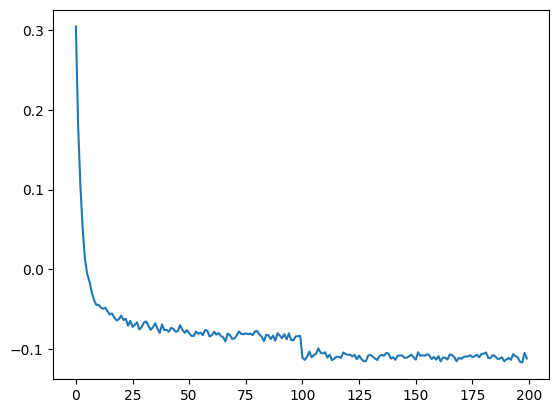

In [52]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [53]:
# Put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [54]:
# Evaluate the loss
@torch.no_grad()  # This decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.784360945224762
val 3.7734837532043457


Context size = 3:
- train 0.9846271872520447
- val 3.433288097381592

Context size = 8:
- train 0.7849294543266296
- val 3.6752207279205322

Obviously for our small training dataset, we shall train for shorter amount of time.

In [55]:
# Sample from the model

for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # Forward pass the nn
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # If we sample the special '.' token, break
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

богослав.
рафаил.
арсениј.
калин.
григориј.
силуан.
самуил.
петар.
неофит.
лав.
павел.
ристе.
сергиј.
војдан.
самуил.
апостол.
велјан.
теодот.
ставре.
владимир.


In [61]:
for word in words[:n1]:
  if word == 'калин':
    print(word)

калин


We can see obvious overfitting.

# WaveNet

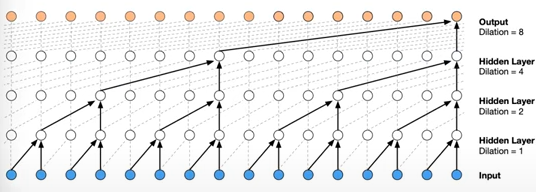

In [58]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  2, 16, 15, 18, 19, 15, 12],
        [ 0,  4, 10, 11,  7, 14, 19, 10],
        [ 0,  0,  0,  0, 22,  2, 17, 10],
        [ 0,  0,  0,  0,  0,  0,  0, 21]])

In [62]:
model.layers[0].out.shape  # Output of Embedding layer

torch.Size([4, 8, 10])

In [63]:
model.layers[1].out.shape  # Output of Flatten layer

torch.Size([4, 80])

We wanna change the outout of the Flatten layer to be like:

(a1 a2) (a3 a4) (a5 a6) etc...

So we want shape of: (4, 4, 20)

In [64]:
model.layers[2].out.shape  # Output of Linear layer

torch.Size([4, 200])

In [68]:
e = torch.randn(4, 8, 10)
e[:, ::2, :].shape, e[:, 1::2, :].shape
# Even characters, odd characters

(torch.Size([4, 4, 10]), torch.Size([4, 4, 10]))

In [71]:
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [74]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [91]:
#@title Layers for WaveNet

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # Note: Kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      if x.ndim == 3:
        dim = (0, 1)
      elif x.ndim == 2:
        dim = 0
      xmean = x.mean(dim, keepdim=True)  # Batch mean
      xvar = x.var(dim, keepdim=True)  # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # Update the buffers (Exponential moving average)
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, ix):
    self.out = self.weight[ix]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(dim=1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # Get the parameters of all layers and stretch them into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [92]:
VOCAB_SIZE = 30 + 1
EMBED_SIZE = 10  # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 200  # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBED_SIZE),
    FlattenConsecutive(n=2), Linear(fan_in=EMBED_SIZE*2, fan_out=HIDDEN_SIZE, bias=False), BatchNorm1d(dim=HIDDEN_SIZE), Tanh(),
    FlattenConsecutive(n=2), Linear(fan_in=HIDDEN_SIZE*2, fan_out=HIDDEN_SIZE, bias=False), BatchNorm1d(dim=HIDDEN_SIZE), Tanh(),
    FlattenConsecutive(n=2), Linear(fan_in=HIDDEN_SIZE*2, fan_out=HIDDEN_SIZE, bias=False), BatchNorm1d(dim=HIDDEN_SIZE), Tanh(),
    Linear(fan_in=HIDDEN_SIZE, fan_out=VOCAB_SIZE),
])

# Parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1  # Make the last layer less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

171741


In [93]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 10, 18, 20, 18],
        [ 0,  0,  0,  2,  6, 17, 10, 28],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0, 14, 10, 11]])

In [94]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 31)


In [95]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 200])

In [96]:
MAX_STEPS = 200000
BATCH_SIZE = 32
lossi = []

for i in range(MAX_STEPS):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
  Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)  # Loss function

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01  # Step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0:  # Print every once in a while
    print(f'{i:7d}/{MAX_STEPS:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4434
  10000/ 200000: 0.6704
  20000/ 200000: 0.7082
  30000/ 200000: 1.1325
  40000/ 200000: 1.0105
  50000/ 200000: 0.6469
  60000/ 200000: 0.4753
  70000/ 200000: 0.7231
  80000/ 200000: 1.0095
  90000/ 200000: 0.9007
 100000/ 200000: 0.6773
 110000/ 200000: 0.8249
 120000/ 200000: 0.8468
 130000/ 200000: 0.7444
 140000/ 200000: 0.7524
 150000/ 200000: 0.8539
 160000/ 200000: 0.7801
 170000/ 200000: 0.8354
 180000/ 200000: 0.8174
 190000/ 200000: 0.5725


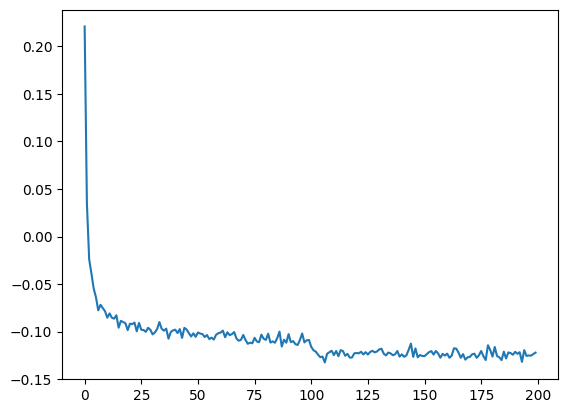

In [97]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [98]:
# Put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

# Evaluate the loss
@torch.no_grad()  # This decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.7767722010612488
val 4.280842304229736


This model is too complex for our tiny dataset. :) --> overfitting!

## Convolutions

In [102]:
for x, y in zip(Xtr[9:15], Ytr[9:15]):
  print(''.join(itos[ix.item()] for ix in x), ',', itos[y.item()])

........ , к
.......к , а
......ка , л
.....кал , и
....кали , н
...калин , .


In [103]:
# Forward a single example
logits = model(Xtr[[9]])
logits.shape

torch.Size([1, 31])

In [105]:
# Forward all of them
logits = torch.zeros(6, VOCAB_SIZE)
for i in range(6):
  logits[i] = model(Xtr[[8+i]])
logits.shape

torch.Size([6, 31])

Convolution is a for loop. It allows us to forward Linear layers efficiently over space.